In [1]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.utils import make_grid, save_image
from matplotlib import pyplot as plt
from PIL import Image
import time
import glob
import math

imagenet-simple-labels

In [29]:
import urllib.request
import json

url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = urllib.request.urlopen(url)
class_names = json.loads(response.read())

# for i in range(20):
#     print(class_names[i])

for i in range(len(class_names)):
    if class_names[i]=='tiger cat': 
        print('tiger cat: ', i)
    if class_names[i]=='Granny Smith': 
        print('Granny Smith: ', i)
    

tiger cat:  282
Granny Smith:  948


In [3]:
import cv2
import torch

def visualize_cam(mask, img):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()
    return heatmap, result

In [4]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
import numpy as np

class GradCAM(object):

    def __init__(self, model_dict):
        layer_name = model_dict['layer_name']
        self.model_arch = model_dict['arch']
        self.gradients = dict()
        self.activations = dict()
        
        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None
        
        if('_' in layer_name ):
            #vgg
            layer_num = int(layer_name.split('_')[1])
            target_layer = self.model_arch.features[layer_num]
        else:
            #resnet
            target_layer = getattr(self.model_arch, layer_name)
            
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)


    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        self.model_arch.eval()
        self.model_arch.cuda()

        logit = self.model_arch(input)
        #Grad-CAM gradient initialization
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)

        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()
        
        #global-average-pooling
        alpha = gradients.view(b, k, -1).mean(2)
        
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        negative_saliency_map = 0 - saliency_map
        
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
        
        negative_saliency_map = F.relu(negative_saliency_map)
        negative_saliency_map = F.upsample(negative_saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        negative_saliency_map_min, negative_saliency_map_max = negative_saliency_map.min(), negative_saliency_map.max()
        negative_saliency_map = (negative_saliency_map - negative_saliency_map_min).div(negative_saliency_map_max - negative_saliency_map_min).data

        return saliency_map, negative_saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

In [5]:
def load_and_normalize_img(img_loc):
    pil_img = PIL.Image.open(img_loc)
    
    normalizer = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    pt_img = torch.from_numpy(np.asarray(pil_img))
    pt_img = pt_img.permute(2, 0, 1) #(channels, height, width)
    pt_img = pt_img.unsqueeze(0)
    pt_img = pt_img.float().div(255).cuda()
    pt_img = F.upsample(pt_img, size=(224, 224), mode='bilinear', align_corners=False)
    normed_torch_img = normalizer(pt_img)
    
    return pt_img, normed_torch_img


# img, norm_img = load_and_normalize_img('/kaggle/input/my-images/cd.png')

In [62]:
def plot_gradcam(model, layer_names, img_loc, class_id=None):
    
    img, norm_img = load_and_normalize_img(img_loc)
        
    fig, axs = plt.subplots(len(layer_names), 4, figsize=(25, 5*len(layer_names)))
    
    for i, layer_name in enumerate(layer_names):
        model_dict = dict(arch=model, layer_name=layer_name, input_size=(224, 224))
        gradcam = GradCAM(model_dict)
        
        if class_id is None:
            mask1, neg_mask1, logit1 = gradcam(norm_img)
            heatmap1, result1 = visualize_cam(mask1.cpu(), img)
            neg_heatmap1, neg_result1 = visualize_cam(neg_mask1.cpu(), img)

            axs[i][0].set_title('Heatmap for layer {} for {}'.format(layer_name, class_names[logit1.argmax().item()]))
            axs[i][1].set_title('GradCAM for {} (class id: {})'.format(class_names[logit1.argmax().item()], logit1.argmax().item()))
            axs[i][0].imshow(heatmap1.permute(1, 2, 0))
            axs[i][1].imshow(result1.permute(1, 2, 0))

            axs[i][2].set_title('Counterfactual Heatmap for layer {}'.format(layer_name))
            axs[i][3].set_title('Counterfactual GradCAM for {} (class id: {})'.format(class_names[logit1.argmax().item()], logit1.argmax().item()))
            axs[i][2].imshow(neg_heatmap1.permute(1, 2, 0))
            axs[i][3].imshow(neg_result1.permute(1, 2, 0))
            
        else:
            mask2, neg_mask2, logit2 = gradcam(norm_img, class_id)
            heatmap2, result2 = visualize_cam(mask2.cpu(), img)
            neg_heatmap2, neg_result2 = visualize_cam(neg_mask2.cpu(), img)
            
            axs[i][0].set_title('Heatmap for layer {} for {}'.format(layer_name, class_names[class_id]))
            axs[i][1].set_title('GradCAM for {} (class id: {})'.format(class_names[class_id], class_id))
            axs[i][0].imshow(heatmap2.permute(1, 2, 0))
            axs[i][1].imshow(result2.permute(1, 2, 0))
            
            axs[i][2].set_title('Counterfactual Heatmap for layer {} for {}'.format(layer_name, class_names[class_id]))
            axs[i][3].set_title('Counterfactual GradCAM for {} (class id: {})'.format(class_names[class_id], class_id))
            axs[i][2].imshow(neg_heatmap2.permute(1, 2, 0))
            axs[i][3].imshow(neg_result2.permute(1, 2, 0))


In [11]:
img_loc = '/kaggle/input/my-images/cd.png'

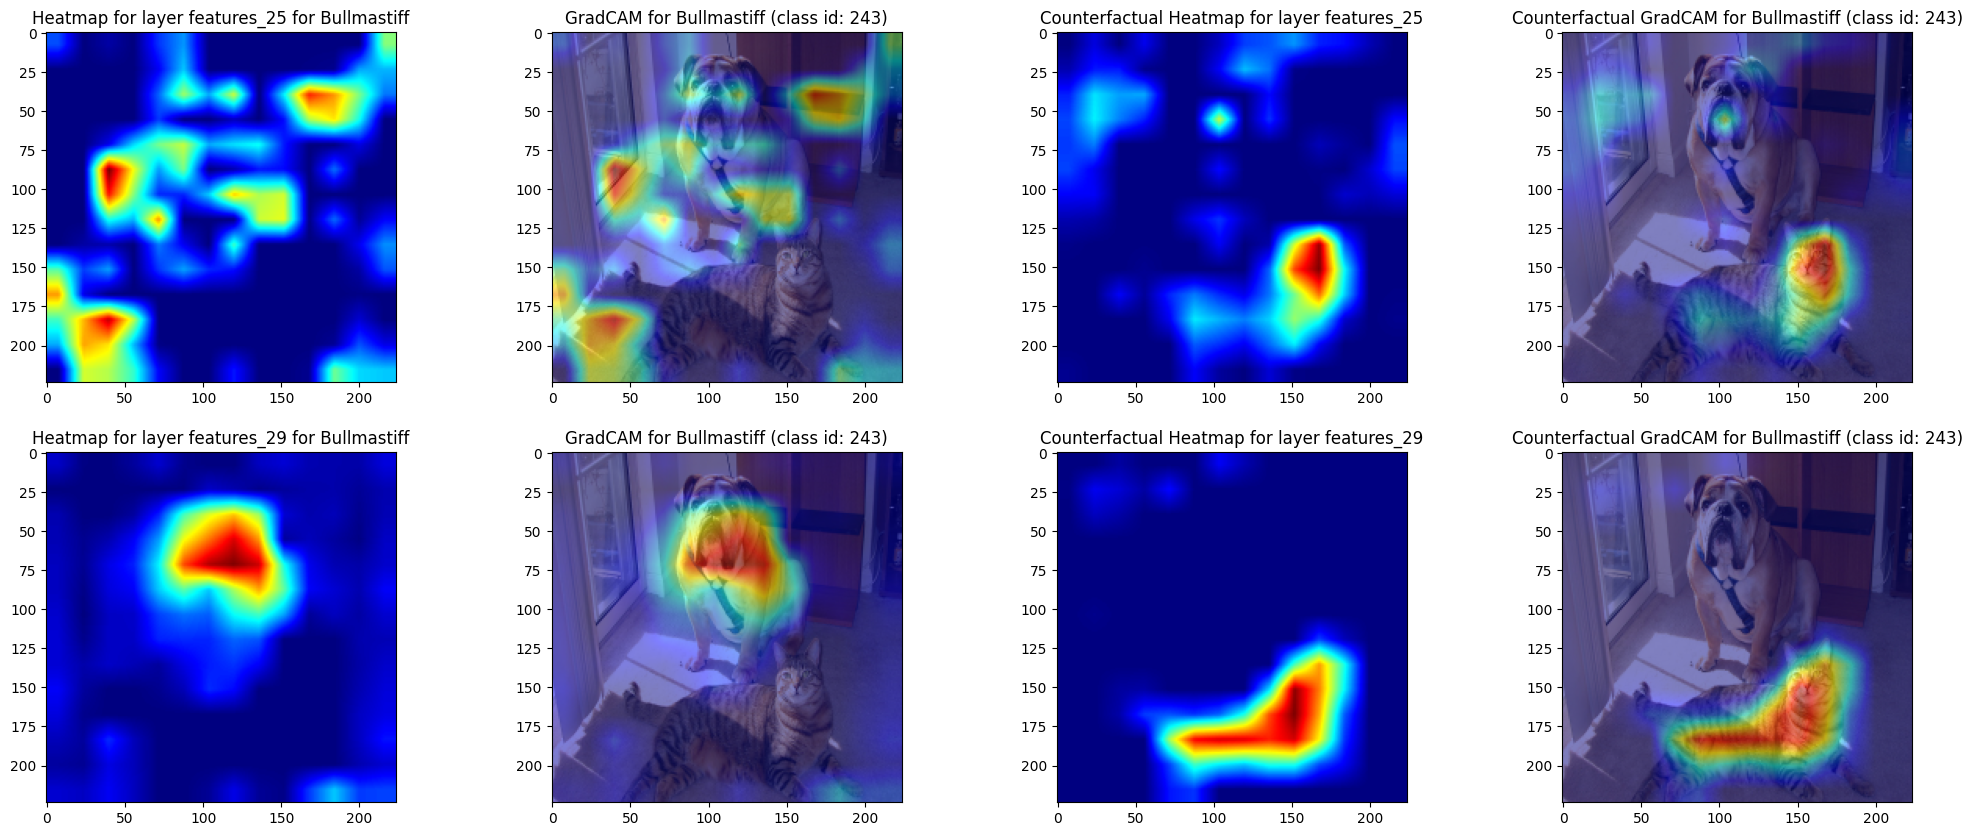

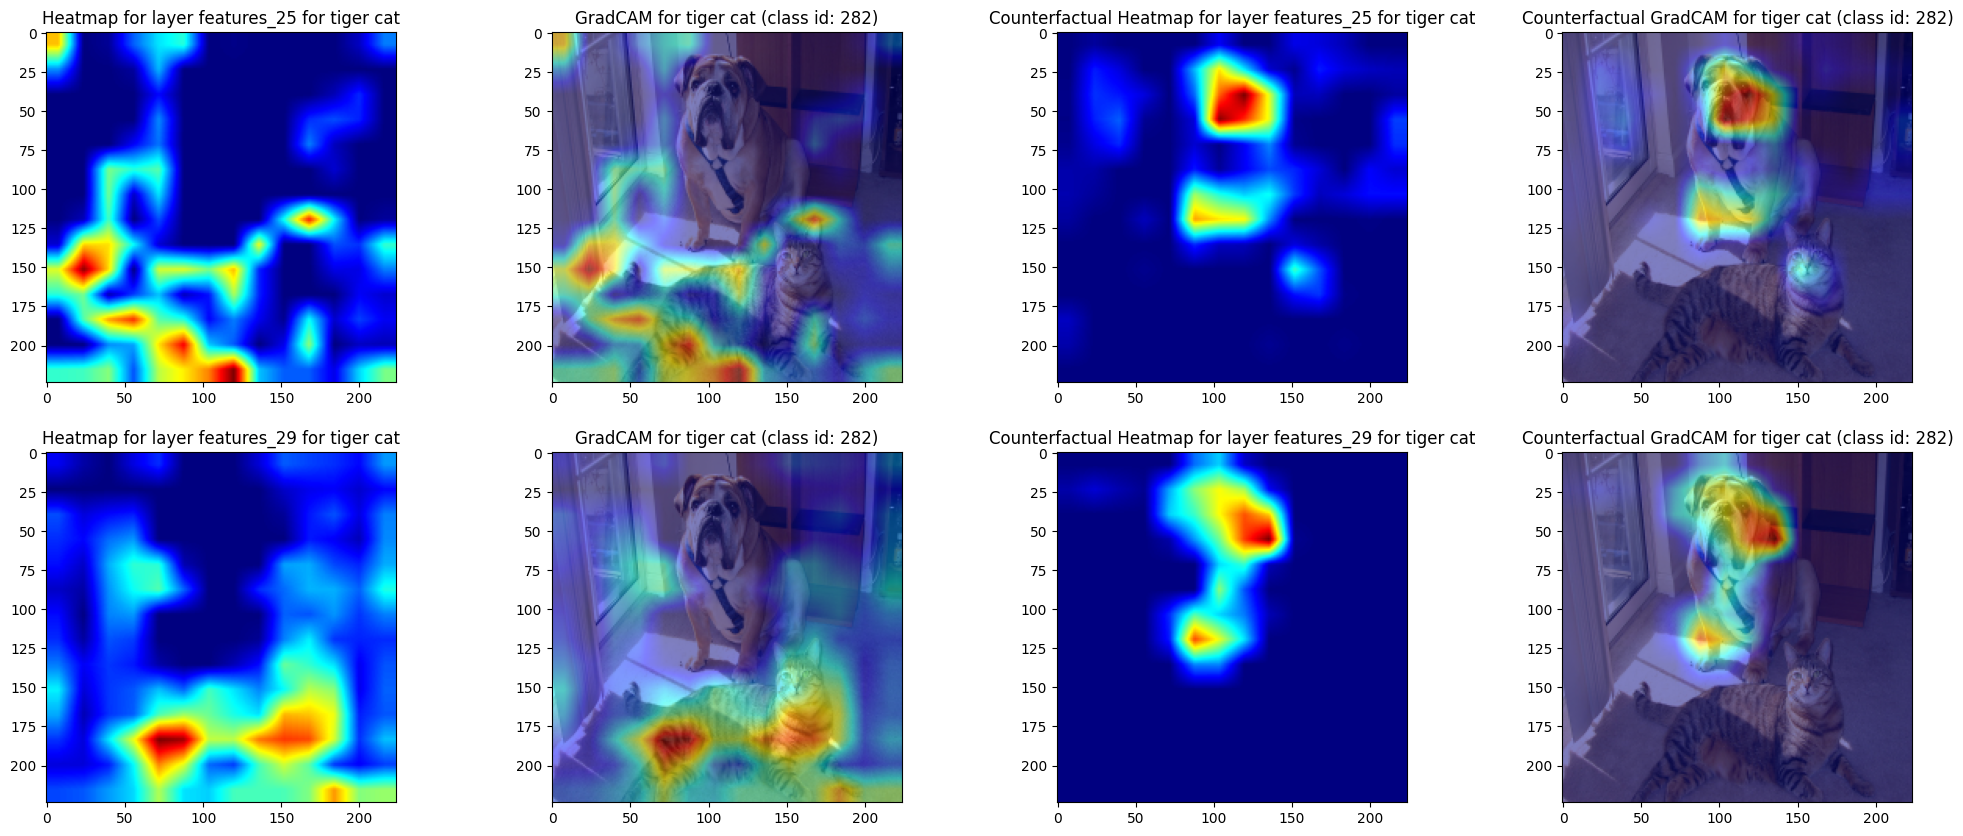

In [12]:
vgg_model = models.vgg16(pretrained=True)
vgg_model.eval(), vgg_model.cuda()
vgg_layers = ['features_25', 'features_29']
plot_gradcam(vgg_model,vgg_layers, img_loc)
plot_gradcam(vgg_model,vgg_layers, img_loc, 282)

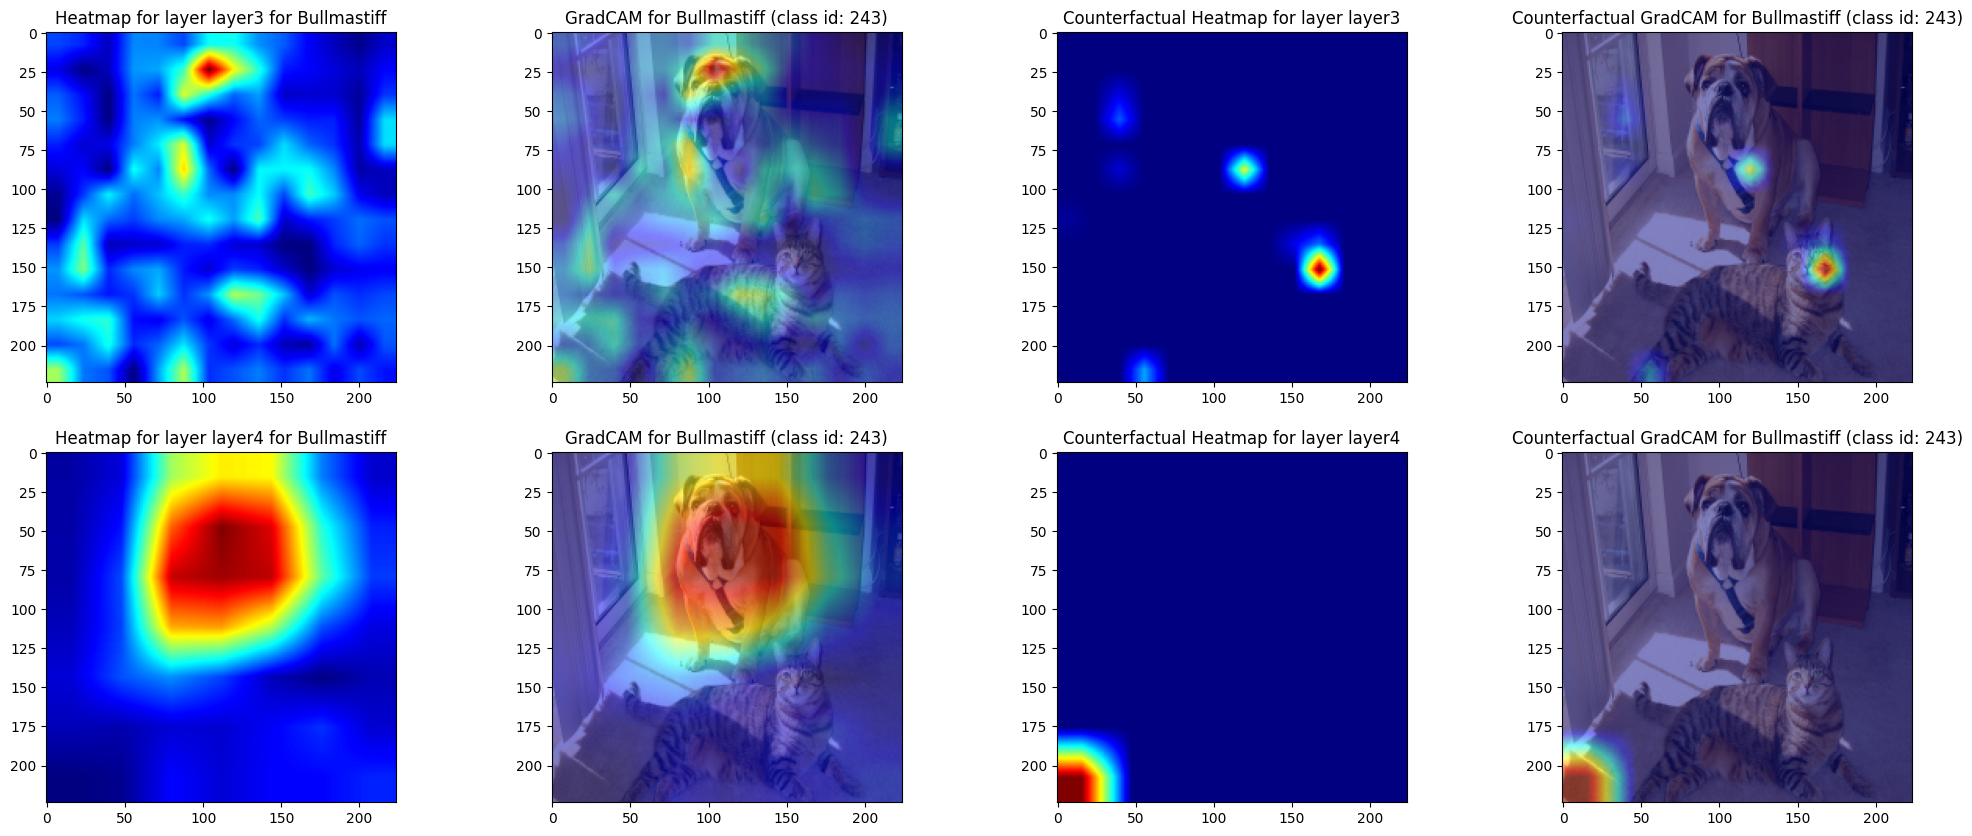

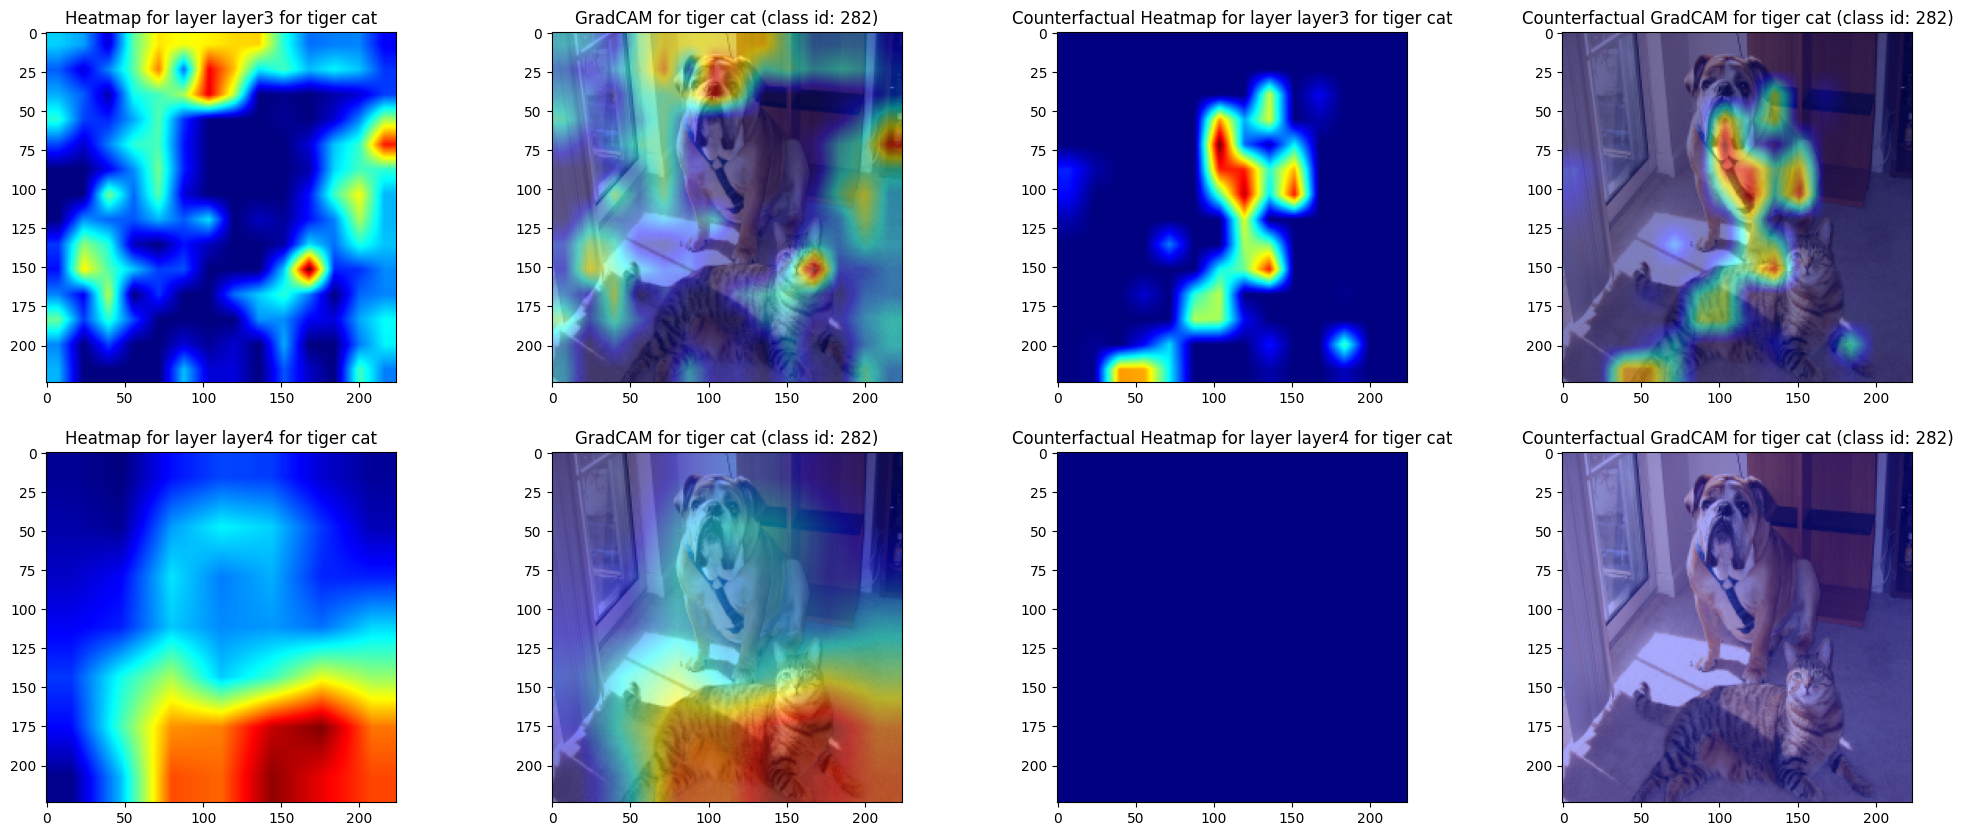

In [13]:
resnet_model = models.resnet50(pretrained=True)
resnet_model.eval(), resnet_model.cuda()
resnet_layers = ["layer3", "layer4"]
plot_gradcam(resnet_model,resnet_layers, img_loc)
plot_gradcam(resnet_model,resnet_layers, img_loc, 282)

## Adversarial Attack

In [19]:
import torchvision.transforms as transforms
from PIL import Image

def predict_image_class(image_path, model, class_names):
    img = Image.open(image_path)

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    img = transform(img)
    img = img.unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = img.to(device)
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(img)
        pred_idx = output.argmax(dim=1).item()
        pred_class = class_names[pred_idx]

    return pred_class

In [55]:
print(predict_image_class('/kaggle/input/apple-adv/apple.JPEG',vgg_model,class_names))
print(predict_image_class('/kaggle/input/apple-adv/apple_adv_vgg16.png',vgg_model,class_names))

Granny Smith
ocarina


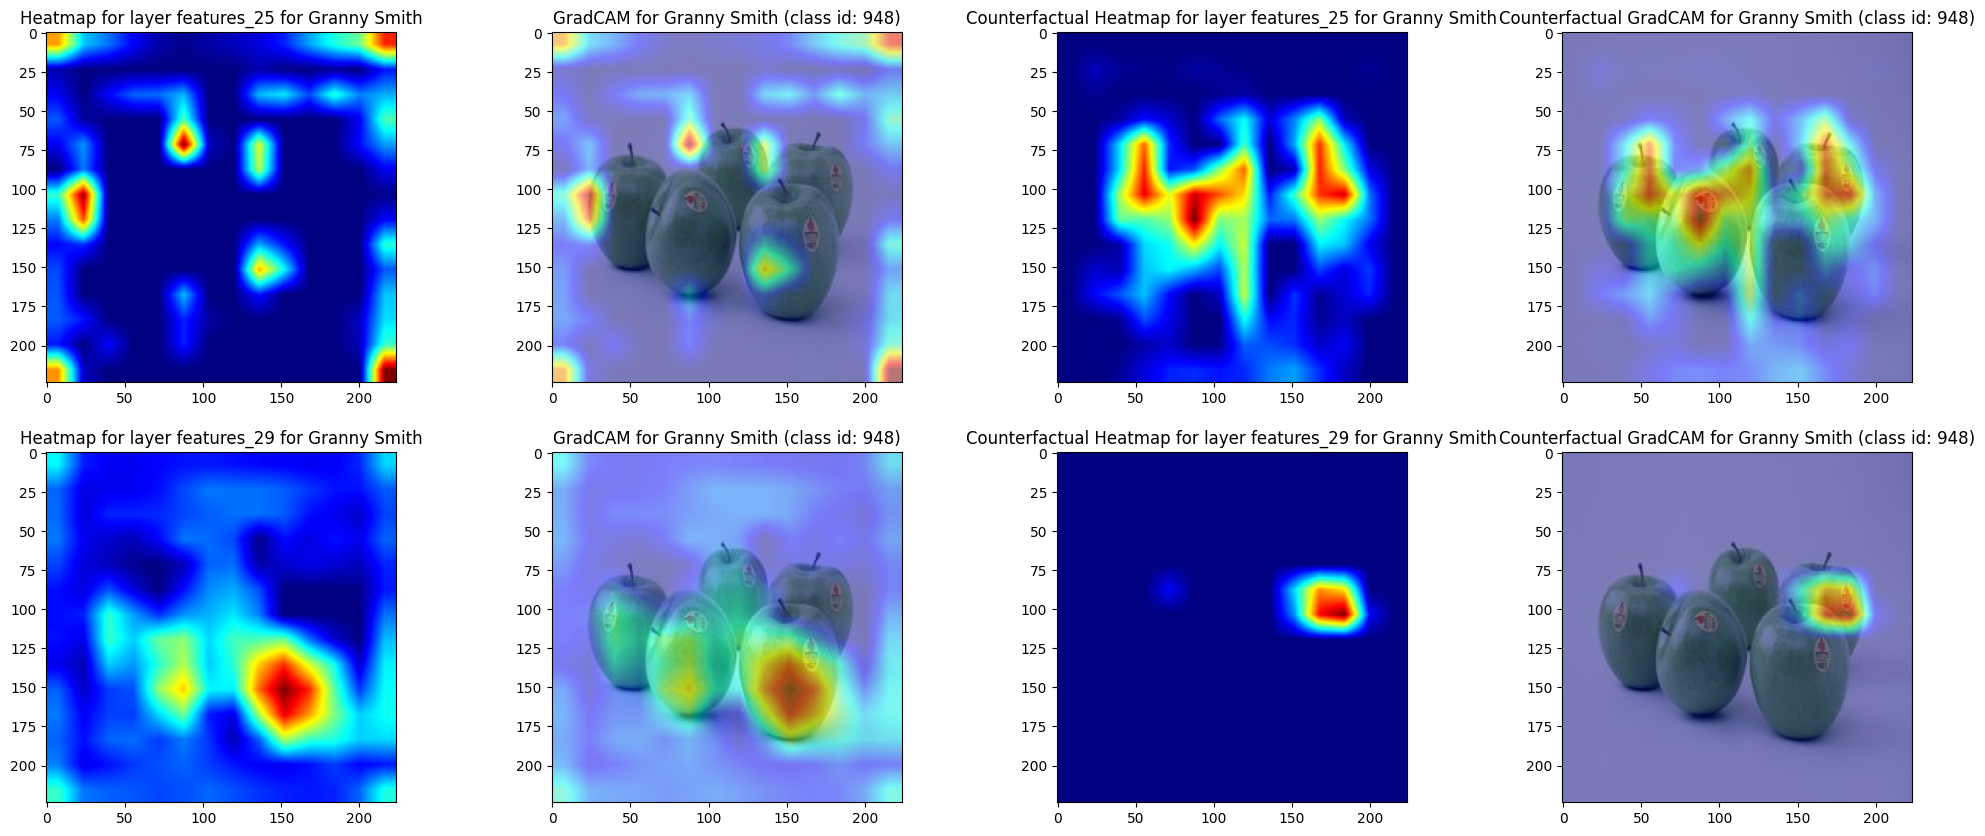

In [61]:
vgg_model = models.vgg16(pretrained=True)
vgg_model.eval(), vgg_model.cuda()
vgg_layers = ['features_25','features_29']
plot_gradcam(vgg_model,vgg_layers, '/kaggle/input/apple-adv/apple.JPEG',948)

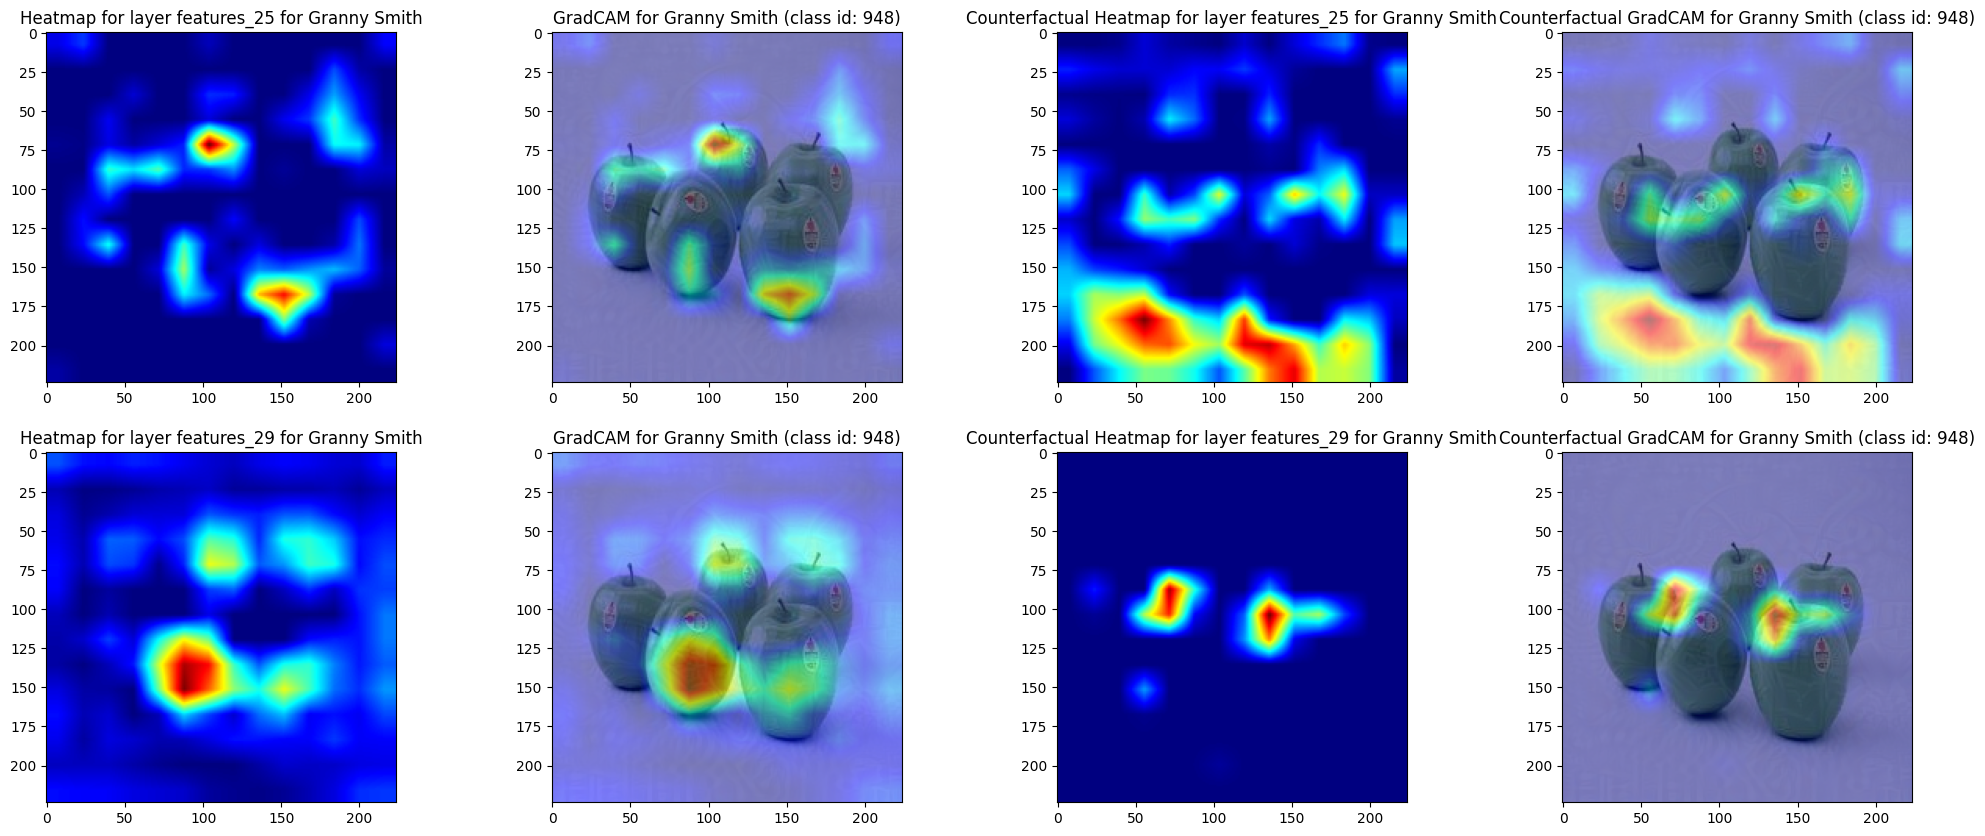

In [24]:
vgg_model = models.vgg16(pretrained=True)
vgg_model.eval(), vgg_model.cuda()
vgg_layers = ['features_25','features_29']
plot_gradcam(vgg_model,vgg_layers, '/kaggle/input/apple-adv/apple_adv_vgg16.png',948)

## Backprop

In [30]:
img, norm_img = load_and_normalize_img('/kaggle/input/my-images/cd.png')

In [31]:
import torch
from torch.nn import ReLU

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [32]:
def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # Mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    im_as_ten = torch.from_numpy(im_as_arr).float()
    im_as_ten.unsqueeze_(0)
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

def get_example_params(example_index):
    img_path = '/kaggle/input/my-images/cd.png'
    target_class = 282
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]

    original_image = Image.open(img_path).convert('RGB')
    prep_img = preprocess_image(original_image)

    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

In [1]:
# # (original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_example_params(282)

# img_path = '/kaggle/input/my-images/cd.png'
# target_class = 282
# original_image = Image.open(img_path).convert('RGB')
# prep_img = preprocess_image(original_image)

# GBP = GuidedBackprop(vgg_model)

# guided_grads = GBP.generate_gradients(prep_img, target_class)
# print('Guided backprop completed')

In [44]:
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_example_params(282)

GBP = GuidedBackprop(pretrained_model)

guided_grads = GBP.generate_gradients(prep_img, target_class)
print('Guided backprop completed')

/tmp/ipykernel_32/851834342.py:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)


Guided backprop completed


In [45]:
# guided_grads

In [46]:
guided_grads = guided_grads - guided_grads.min()
guided_grads /= guided_grads.max()

(-0.5, 223.5, 223.5, -0.5)

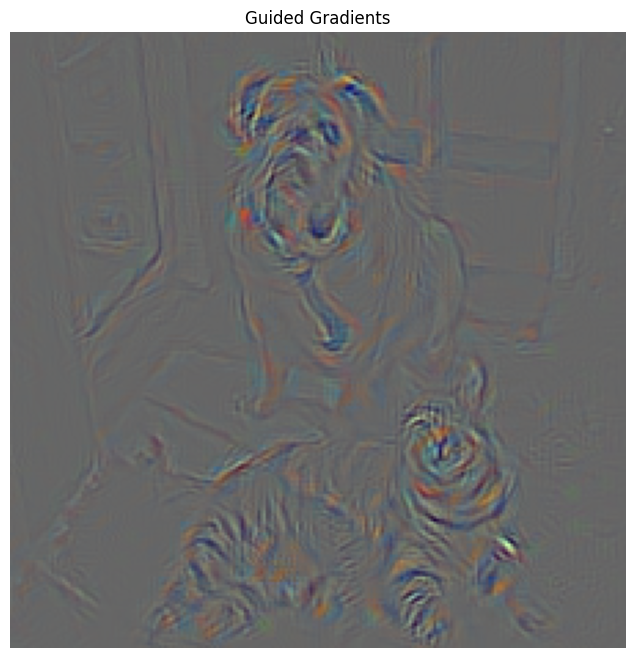

In [47]:
# Plot guided gradients
plt.figure(figsize=(8,8))
plt.imshow(torch.from_numpy(guided_grads).permute(1,2,0))
plt.title('Guided Gradients')
plt.axis('off')

In [48]:
model_dict = dict(arch=vgg_model, layer_name='features_29', input_size=(224, 224))
gradcam = GradCAM(model_dict)
mask, neg_mask, logit = gradcam(norm_img)
heatmap, result = visualize_cam(mask.cpu(), img)
neg_heatmap, neg_result = visualize_cam(neg_mask.cpu(), img)

In [49]:
guided = torch.from_numpy(guided_grads).permute(1,2,0)
guided_reshaped = guided.permute(2, 0, 1)
print(heatmap.shape, guided_reshaped.shape)

torch.Size([3, 224, 224]) torch.Size([3, 224, 224])


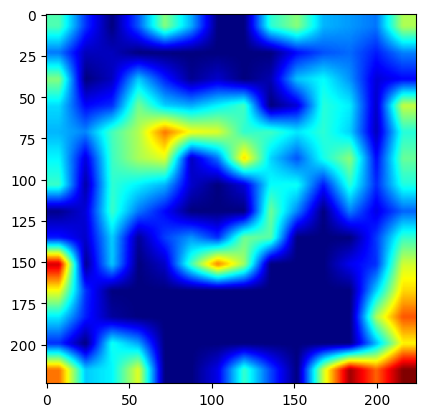

In [50]:
plt.imshow(heatmap.permute(1, 2, 0))

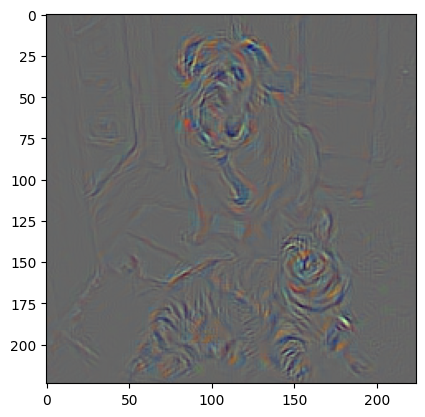

In [51]:
plt.imshow(guided_reshaped.permute(1, 2, 0))

In [52]:
import torch.nn.functional as F

result = heatmap * guided_reshaped
result_relu = F.relu(result)

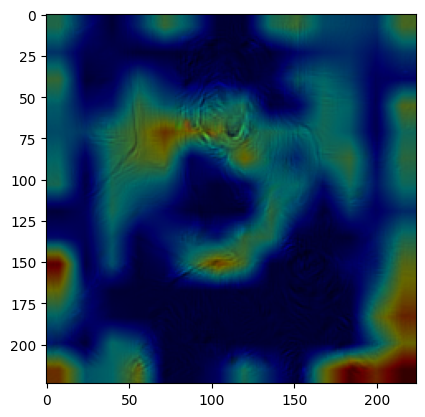

In [53]:
plt.imshow(result_relu.permute(1, 2, 0))

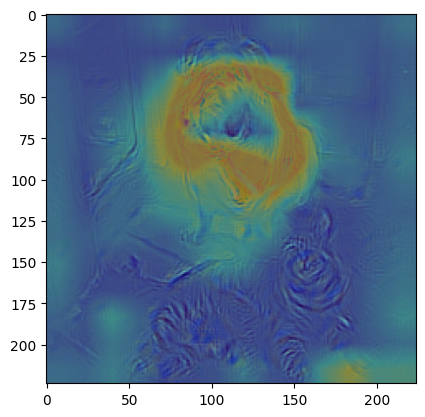

In [141]:
import torch.nn.functional as F
import numpy as np

result = heatmap * guided_reshaped
result_relu = F.relu(result)

heatmap_ggc = torch.sum(result_relu, dim=0)

heatmap_ggc = F.relu(heatmap_ggc)

heatmap_ggc /= torch.max(heatmap_ggc)

guided_ggc = guided.cpu().numpy()
guided_ggc = np.uint8(255 * guided_ggc)
heatmap_ggc = np.uint8(255 * heatmap_ggc)
heatmap_ggc = cv2.applyColorMap(heatmap_ggc, cv2.COLORMAP_JET)
guided_ggc = heatmap_ggc * 0.3 + guided_ggc * 0.5

guided_ggc = cv2.cvtColor(np.uint8(guided_ggc), cv2.COLOR_BGR2RGB)
# plt.imshow(heatmap_ggc)
plt.imshow(guided_ggc)
plt.show()
